<a href="https://colab.research.google.com/github/AySay02/SkimLit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION :-


1.   Basically works on Many-to-One sequence problem.
2.   Taking a sample dataset from PubMed of medical research papers.
3.   Divides the abstract to - Obj, methods, res , conclusion sub sections.



# Getting DATA

In [ ]:
# Getting DATA
# downloading pubmed 200k RCT data

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.11 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start experimenting with 20k dataset with nums replaced by @
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# getting helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2023-06-09 07:27:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-09 07:27:29 (93.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# DATA Preprocessing and visualisation

In [ ]:
# function to read the lines of doc

def get_lines(filename):
  """
  Reads filename and returns lines of text as list
  Args : file path
  """

  with open(filename , "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

**We want our data to look like :**\
> List of dictionaries\
> [{'line_number : 0,
    'target : 'BACKGROUND',
    'text' : 'sentence of that line',
    'total_lines': num}]

In [ ]:
# Making a function to structure our data for modelling

def preprocess_text(filename):
  """
  Returns a list of dictionaries of abstract of line data
  arg : file path
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create empty abstract
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):  # new abstract is starting
      abstract_id = line
      abstract_lines = "" # reset the abstract line for new abstract
    elif line.isspace():  # check to see if new line
      abstract_line_split = abstract_lines.splitlines()   # split abstract into separate lines

      for abstract_line_num , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")     # separates label from text
        line_data["target"] = target_text_split[0]  # get label
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_num
        line_data["total lines"] = len(abstract_line_split)-1 # total lines in target abstract
        abstract_samples.append(line_data)

    else: # for labelled lines
      abstract_lines += line

  return abstract_samples


In [ ]:
train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")

len(train_samples) , len(val_samples) , len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(12)

,target,text,line_number,total lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

**GET LISTS OF SENTENCES**

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences)

180040

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

# Turning labels and data to numbers

In [ ]:
# making numeric labels

# one hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)  # tensorflow is incompatible with sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])




**Label encode labels**




In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded , val_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]), array([0, 0, 3, ..., 4, 1, 1]))

In [ ]:
# Get class names and num_classes

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# TF-IDF classifier using Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline

model_0 = Pipeline([
    ("tfidf" , TfidfVectorizer()),
    ("clf" , MultinomialNB())
])

model_0.fit(train_sentences , train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences , val_labels_encoded)
print(f"Baseline accuracy : {baseline_score*100:.2f}%")

Baseline accuracy : 72.18%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
baseline_res = calculate_results(y_true = val_labels_encoded,
                                 y_pred = baseline_preds)
baseline_res

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# TOKENIZATION and EMBEDDING

In [ ]:
MAX_LENGTH = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
sent_len = [len(i.split()) for i in train_sentences]
MAX_LENGTH

26

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

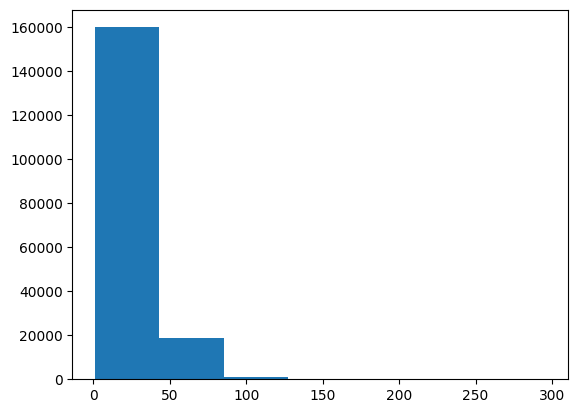

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_len, bins=7)

In [ ]:
import numpy as np

output_seq_len = int(np.percentile(sent_len , 95))
output_seq_len

55

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 68000  # given in pubmed research paper
max_length = output_seq_len

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length = max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sent = train_sentences[0]
sample_sent , len(sample_sent)

('to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 281)

In [ ]:
sample_vect = text_vectorizer([sample_sent])
sample_vect

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
           5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
        1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
         350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:

word_in_vocab = text_vectorizer.get_vocabulary()
top_5 = word_in_vocab[:5]
least_5 = word_in_vocab[-5:]

print(f"Top 5 words : {top_5}")
print(f"Least 5 words : {least_5}")
len(word_in_vocab)

Top 5 words : ['', '[UNK]', 'the', 'and', 'of']
Least 5 words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


64841

In [ ]:
# create embedding layer

from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim = len(word_in_vocab),
                      output_dim = 128,
                      mask_zero = True,
                      name="token_embedding"
                      )
token_embed


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
embedded_sample = token_embed(sample_vect)
embedded_sample

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.0051092 ,  0.0343748 ,  0.00346627, ..., -0.02653788,
          0.00856883, -0.01416217],
        [ 0.02220942,  0.01471282,  0.03812477, ...,  0.03620515,
         -0.00141878,  0.0170457 ],
        [-0.03616823,  0.03506574,  0.0176458 , ..., -0.03370549,
         -0.00229152, -0.00123086],
        ...,
        [ 0.01613399,  0.02930197,  0.00316303, ...,  0.01205319,
          0.02948317,  0.02022662],
        [ 0.01613399,  0.02930197,  0.00316303, ...,  0.01205319,
          0.02948317,  0.02022662],
        [ 0.01613399,  0.02930197,  0.00316303, ...,  0.01205319,
          0.02948317,  0.02022662]]], dtype=float32)>

# Creating fast loading dataset
Basically reduced the gap between data preparation and it's GPU utilization

In [ ]:
# turn our data into tensorflow datasets
import tensorflow as tf


train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset , train_labels_one_hot.shape

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 (180040, 5))

In [ ]:
# Take TensorSliceDataset and turn them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # read the documentation
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Conv1D Model

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype="string")
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64 , kernel_size = 5 , padding="same" , activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes , activation="softmax")(x)

model_1 = tf.keras.Model(inputs , outputs , name="Conv1d_model")

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

there are 5627 in train_dataset, we train on only 10% of it

In [ ]:
model1_hist = model_1.fit(train_dataset,
                          steps_per_epoch = int(0.1*len(train_dataset)),  # runs only on 10 percent data
                          epochs=5,
                          validation_data=valid_dataset,
                          validation_steps= int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 44s 59ms/step - loss: 0.9169 - accuracy: 0.6357 - val_loss: 0.6830 - val_accuracy: 0.7420
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6571 - accuracy: 0.7565 - val_loss: 0.6318 - val_accuracy: 0.7739
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.6176 - accuracy: 0.7746 - val_loss: 0.5957 - val_accuracy: 0.7832
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5887 - accuracy: 0.7877 - val_loss: 0.5772 - val_accuracy: 0.7922
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5907 - accuracy: 0.7926 - val_loss: 0.5586 - val_accuracy: 0.7975


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5596 - accuracy: 0.8009


[0.5595941543579102, 0.8008738160133362]

In [ ]:
# making preds

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs , axis=1)


945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_preds , class_names

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
model_1_res = calculate_results(val_labels_encoded,
                                model_1_preds)
model_1_res

{'accuracy': 80.08738249702105,
 'precision': 0.8005328584926127,
 'recall': 0.8008738249702105,
 'f1': 0.797699132140414}

# TF pretrained Feature
The paper used the GloVe embedding(google it) but we are using USE

In [ ]:
# downloading pretrained model

import tensorflow_hub as hub

USE_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           name="universal_sentence_encoder")

In [ ]:
import random
random_sent = random.choice(train_sentences)
print(random_sent)

rand_embed_sent = USE_embed([random_sent])
rand_embed_sent[0]

there were @ patients in our study .


<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([-2.84736548e-02,  4.07172740e-02, -9.15925112e-03,  6.32732268e-03,
        4.65194741e-03,  1.45925283e-02,  2.07002461e-02,  1.76919699e-02,
       -4.52979840e-02, -5.52027002e-02,  7.92529359e-02,  1.35193882e-03,
        9.43270698e-02,  8.98169503e-02, -3.69646624e-02, -1.42909661e-02,
       -9.58322808e-02, -7.14400560e-02, -2.70264549e-03, -8.50730985e-02,
       -7.47380080e-03,  3.74653153e-02, -4.84748967e-02, -7.47178569e-02,
       -1.68162994e-02, -9.75853018e-03,  2.75137369e-02,  5.60362823e-02,
        6.51295185e-02,  3.69787887e-02,  3.83018367e-02,  9.96715948e-02,
       -1.55584095e-02,  1.61193684e-02, -5.29605560e-02, -2.63707433e-02,
       -4.67945449e-02, -1.92561857e-02, -2.66144052e-02, -5.38669527e-02,
       -5.65973930e-02,  6.39811084e-02, -4.35617603e-02,  4.66926284e-02,
       -4.87159123e-05,  3.79428044e-02, -2.40767524e-02,  5.87181598e-02,
        1.31287577e-03, -5.79132736e-02, -3.18831764

In [ ]:
# building the model
from tensorflow.keras import layers

inputs = layers.Input(shape=[] , dtype="string")  # shape is null as given in USE doc
pretrain_embedding = USE_embed(inputs)
x = layers.Dense(128 , activation="relu")(pretrain_embedding)   # more layers can be added
outputs = layers.Dense(num_classes , activation="softmax")(x)

model_2 = tf.keras.Model(inputs,outputs,name="USE_feature_extractor")

model_2.compile(loss = "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model2_hist = model_2.fit(train_dataset,
                          steps_per_epoch = int(0.1*len(train_dataset)),  # runs only on 10 percent data
                          epochs=5,
                          validation_data=valid_dataset,
                          validation_steps= int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9152 - accuracy: 0.6509 - val_loss: 0.7960 - val_accuracy: 0.6902
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7672 - accuracy: 0.7033 - val_loss: 0.7528 - val_accuracy: 0.7061
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7503 - accuracy: 0.7140 - val_loss: 0.7375 - val_accuracy: 0.7141
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7170 - accuracy: 0.7261 - val_loss: 0.7098 - val_accuracy: 0.7314
Epoch 5/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7235 - accuracy: 0.7233 - val_loss: 0.6900 - val_accuracy: 0.7337


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.6963 - accuracy: 0.7360


[0.6962890028953552, 0.7360320687294006]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs , axis=1)


945/945 [==============================] - 11s 12ms/step


In [ ]:
model_2_res = calculate_results(val_labels_encoded,
                                model_2_preds)
model_2_res

{'accuracy': 73.60320402489077,
 'precision': 0.7316990755462717,
 'recall': 0.7360320402489077,
 'f1': 0.7301407900142479}

# Character Embedding
Conv1D with character embedding
>Similar but for the use of char-level embedding rather than token-level


**Creating Character level tokenizer**

In [ ]:
# Making function to split sentences into chars

def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# splitting sequence level data

train_chars = [split_chars(sent) for sent in train_sentences]
val_chars = [split_chars(sent) for sent in val_sentences]
test_chars = [split_chars(sent) for sent in test_sentences]

train_chars[1]

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [ ]:
# getting avg character length

char_lens = [len(sent) for sent in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

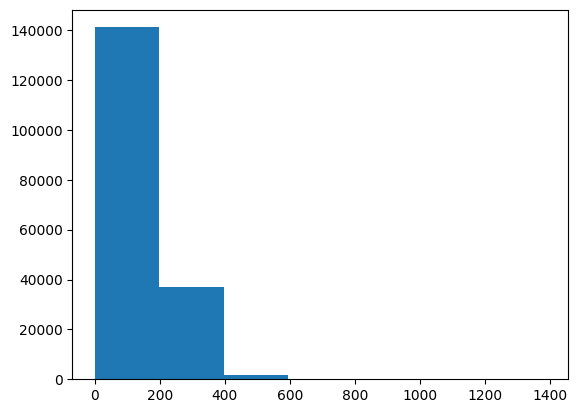

In [ ]:
# checking the distribution

plt.hist(char_lens , bins=7)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens , 95))
output_seq_char_len

290

In [ ]:
# getting all keyboard characters to get max number of char used
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Creating char-level vectorizer**

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # adding 2 for space and OOV token(out of vocab)
char_vectorizer  = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                     output_sequence_length = output_seq_char_len,
                                     name="char_Vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [ ]:
print("Most 5 common chars" , char_vocab[:5])
print("Least 5" , char_vocab[-5:])

Most 5 common chars ['', '[UNK]', 'e', 't', 'i']
Least 5 ['k', 'x', 'z', 'q', 'j']


In [ ]:
rand_vect_char = char_vectorizer([train_chars[69]])
rand_vect_char

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[17,  7,  8,  3, 19,  3, 20,  7, 14,  8,  5, 11,  3,  4, 11,  2,
         9, 17,  8,  7, 15,  3, 13,  2, 14,  2, 10,  4,  5,  3,  8,  4,
        11,  8,  2,  9,  2,  5,  8, 11, 13,  4,  6,  7, 17, 17,  4, 11,
         2,  9,  2,  3,  3,  4,  6, 18,  9,  6,  2,  3, 20,  7,  8, 23,
         7, 17,  3, 13,  2,  5, 15,  2,  8,  4, 11,  5,  6,  5, 11,  5,
        10,  2, 15, 19,  7, 17, 14,  2, 10,  4,  5,  3,  8,  4, 11,  9,
        20,  2,  8,  2,  8,  5,  6, 10,  7, 15, 12, 19,  5,  9,  9,  4,
        18,  6,  2, 10,  3,  7,  7, 17, 18,  8,  7, 16, 14,  9,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

*CREATING THE CHAR-LEVEL embedding layer*

In [ ]:
from tensorflow.keras.layers import Embedding

char_embed = Embedding(input_dim = len(char_vocab),
                       output_dim = 25,   # given in paper
                       mask_zero=True,
                       name="Char_embed")
char_embed

In [ ]:
rand_char_emb = char_embed(rand_vect_char)
rand_char_emb

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.02956644,  0.02758009, -0.03273835, ...,  0.00192919,
          0.01400113, -0.04721702],
        [-0.01370498, -0.01101298,  0.01001031, ...,  0.01981342,
          0.00447967,  0.04063064],
        [ 0.03633206, -0.04903979, -0.01180802, ..., -0.00879902,
          0.02797344, -0.01315396],
        ...,
        [ 0.01524309,  0.00592313,  0.00242864, ..., -0.04893206,
          0.02659884, -0.03038951],
        [ 0.01524309,  0.00592313,  0.00242864, ..., -0.04893206,
          0.02659884, -0.03038951],
        [ 0.01524309,  0.00592313,  0.00242864, ..., -0.04893206,
          0.02659884, -0.03038951]]], dtype=float32)>

# Conv1D with char-embedding

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

inputs = layers.Input(shape=(1,) , dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64 , kernel_size = 5, padding="same" , activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes , activation = "softmax")(x)
model_3 = tf.keras.Model(inputs , outputs , name = "Conv1d_char")

model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam() ,
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "Conv1d_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_Vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 Char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_7 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_10 (Dense)            (None, 5)                 

In [ ]:
import tensorflow as tf


train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_char

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model3_hist = model_3.fit(train_dataset_char,
                          steps_per_epoch = int(0.1*len(train_dataset_char)),
                          epochs=5,
                          validation_data = valid_dataset_char,
                          validation_steps=int(0.1*len(valid_dataset_char)))

Epoch 1/5
562/562 [==============================] - 5s 6ms/step - loss: 1.2778 - accuracy: 0.4811 - val_loss: 1.0540 - val_accuracy: 0.5798
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0082 - accuracy: 0.5925 - val_loss: 0.9616 - val_accuracy: 0.6197
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9381 - accuracy: 0.6311 - val_loss: 0.8895 - val_accuracy: 0.6489
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8849 - accuracy: 0.6552 - val_loss: 0.8633 - val_accuracy: 0.6513
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8699 - accuracy: 0.6625 - val_loss: 0.8441 - val_accuracy: 0.6719


In [ ]:
model_3_pred_probs = model_3.predict(valid_dataset_char)
model_3_preds = tf.argmax(model_3_pred_probs , axis=1)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_3_res = calculate_results(val_labels_encoded,
                                model_3_preds)
model_3_res

{'accuracy': 66.82113067655237,
 'precision': 0.67353800857584,
 'recall': 0.6682113067655236,
 'f1': 0.663791218621792}

# MultiInput model
token embedding + char embedding (hybrid)\
>Architecture of model taken from paper with a few changes

In [ ]:
# Setup token inputs
from tensorflow.keras import layers

token_inputs = layers.Input(shape = [] , dtype = tf.string , name ="token_input")
token_embeddings = USE_embed(token_inputs)

token_outputs = layers.Dense(128 , activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)


# Setup char inputs/model
char_inputs = layers.Input(shape = (1,) , dtype = "string" , name="char_input")
char_vect = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vect)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi-LSTM; shown in fig in paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)   # 24 will get doubled as its bidirectional


# Concatenate the models - hybrid token embedding

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# passing the outputs and combining them


# Create outputs layers ; adding in dropout layer- which does regularization and avoids overfitting; check doc

combined_dropout = layers.Dropout(0.5)(token_char_concat)   # rate =0.5 given in paper
combined_dense = layers.Dense(128 , activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes , activation="softmax")(final_dropout)



# Construct model using token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs = output_layer,
                         name="model_4_hybrid")



In [ ]:
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_Vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]'

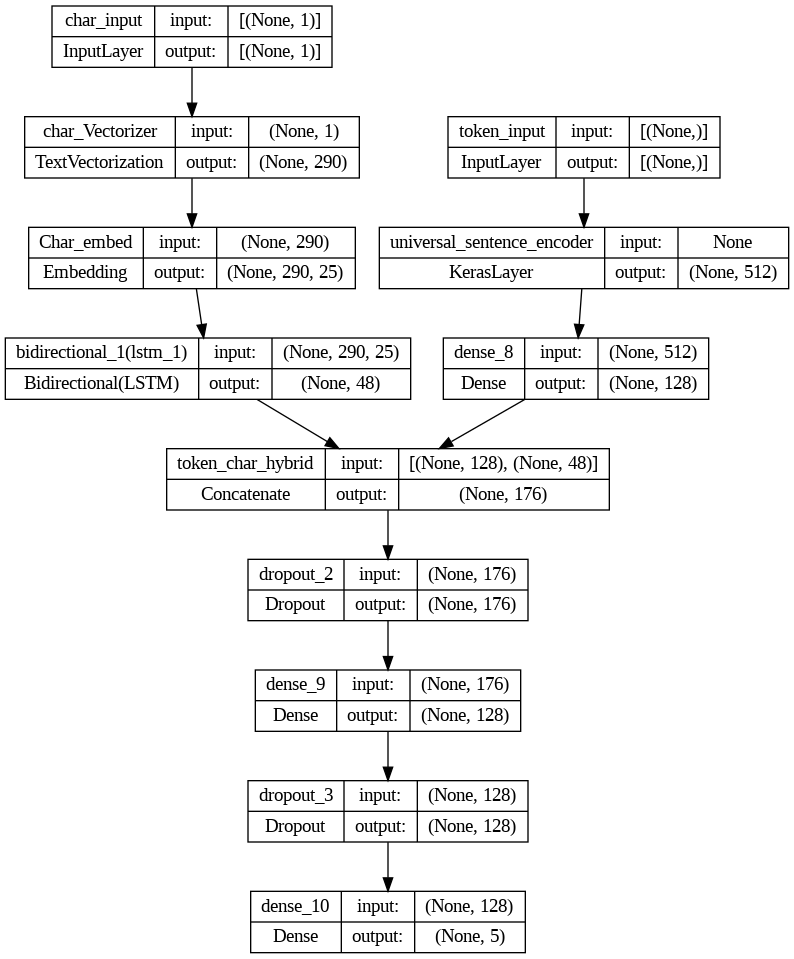

In [ ]:
# Plotting hybrid model

from keras.utils import plot_model

plot_model(model_4 , show_shapes=True)

In [ ]:
# compiling the model

model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

**Creating fast loading multi-input dataset**

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))   # passing tuple as input
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data , train_token_char_labels ))

# prefetching

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))   # passing tuple as input
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data , val_token_char_labels ))

# prefetching

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**NOTE:- ORDER OF INPUT DEFINED IN MODEL ARCHITECTURE SHOULD BE SAME**

In [ ]:
# fitting the model

model4_hist = model_4.fit(train_token_char_dataset,
                          steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                          epochs=5,
                          validation_data = val_token_char_dataset,
                          validation_steps = int(0.1*len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 45s 57ms/step - loss: 0.9827 - accuracy: 0.6102 - val_loss: 0.7982 - val_accuracy: 0.6918
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.8036 - accuracy: 0.6877 - val_loss: 0.7247 - val_accuracy: 0.7241
Epoch 3/5
562/562 [==============================] - 29s 52ms/step - loss: 0.7825 - accuracy: 0.6997 - val_loss: 0.6933 - val_accuracy: 0.7367
Epoch 4/5
562/562 [==============================] - 34s 60ms/step - loss: 0.7478 - accuracy: 0.7194 - val_loss: 0.6683 - val_accuracy: 0.7507
Epoch 5/5
562/562 [==============================] - 31s 56ms/step - loss: 0.7518 - accuracy: 0.7157 - val_loss: 0.6596 - val_accuracy: 0.7500


***make test dataset for this for evaluating***

In [ ]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 29s 31ms/step - loss: 0.6672 - accuracy: 0.7450


[0.6671732664108276, 0.7450351119041443]

In [ ]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs , axis=1)
model_4_preds

945/945 [==============================] - 38s 36ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_res = calculate_results(val_labels_encoded,
                                model_4_preds)
model_4_res

{'accuracy': 74.50350853965311,
 'precision': 0.7420234238836386,
 'recall': 0.7450350853965312,
 'f1': 0.73951387395801}

# Token + Char + POSITIONAL EMBEDDING Model

In [ ]:
train_df.head()

,target,text,line_number,total lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


>Note: Any engineered features used to train a model need to be available at test time. In our case , line numbers and total lines are available

**Creating POSITIONAL EMBEDDING**

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
# Using tensorflow to create one hot encoded tensors for line numbers

train_line_nos_one_hot = tf.one_hot(train_df["line_number"].to_numpy() , depth=15)  #till 15 we get max data
val_line_nos_one_hot = tf.one_hot(val_df["line_number"].to_numpy() , depth=15)
test_line_nos_one_hot = tf.one_hot(test_df["line_number"].to_numpy() , depth=15)

train_line_nos_one_hot[:10] , train_line_nos_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df["total lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total lines, dtype: int64

In [ ]:
# selecting 20 cz covers majority

train_total_lines_one_hot = tf.one_hot(train_df["total lines"].to_numpy() , depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total lines"].to_numpy() , depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total lines"].to_numpy() , depth=20)

train_total_lines_one_hot.shape

TensorShape([180040, 20])

**Building the tribid embedding model**

In [ ]:
from tensorflow.keras import layers

# Creating a token-level inputs

token_inp = layers.Input(shape=[] , dtype=tf.string , name="Token-level inputs")
token_emb = USE_embed(token_inp)
token_out = layers.Dense(128 , activation="relu")(token_emb)
token_model = tf.keras.Model(inputs=token_inp,
                             outputs=token_out)


# Creating char-level inputs

char_inp = layers.Input(shape=(1,) , dtype="string" , name="char-level inputs")
char_vc = char_vectorizer(char_inp)
char_emb = char_embed(char_vc)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_emb)
char_model = tf.keras.Model(char_inp,
                            char_bi_lstm)

# Creating positional-level inputs - line nums

ln_inp = layers.Input(shape=(15,) , dtype=tf.float32 , name="line_num_inputs")
x = layers.Dense(32 , activation="relu")(ln_inp)
ln_model = tf.keras.Model(ln_inp,
                          x)

# for total lines

tl_inp = layers.Input(shape=(20,) , dtype=tf.float32 , name="total_lines_inputs")
y = layers.Dense(32 , activation="relu")(tl_inp)
tl_model = tf.keras.Model(inputs=tl_inp,
                          outputs=y)

# Combining token and char to make hybrid embeddings

combined_embeddings = layers.Concatenate(name="char_token_hybrid_emb")([token_model.output,
                                                                        char_model.output])

# passing to dropout layer

z = layers.Dense(256 , activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embedding with hybrid - tribrid mix

tribrid_embeddings = layers.Concatenate(name="char_token_positional_emb")([ln_model.output,
                                                                          tl_model.output,
                                                                          z])

# Creating output layer

output_layer = layers.Dense(num_classes,activation="softmax",
                            name="output_layer")(tribrid_embeddings)

# Creating the model

model_5 = tf.keras.Model(inputs=[ln_model.input,
                                 tl_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid")



In [ ]:
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char-level inputs (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 Token-level inputs (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 char_Vectorizer (TextVectoriza  (None, 290)         0           ['char-level inputs[0][0]']      
 tion)                                                                                            
                                                                                    

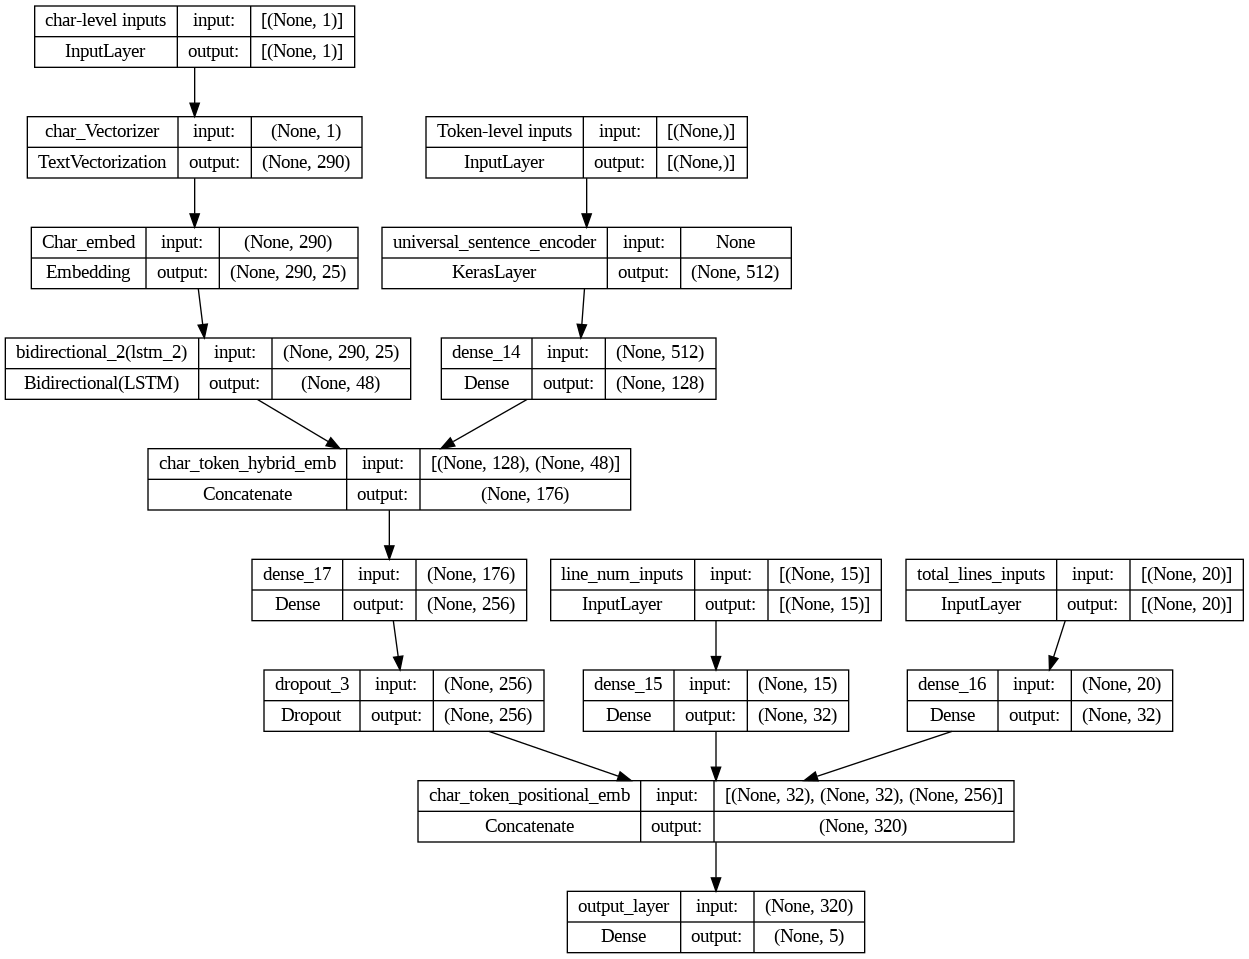

In [ ]:
from keras.utils import plot_model

plot_model(model_5 , show_shapes=True)

In [ ]:
model_5.compile(loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.2),  # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


*CREATING A FAST LOADING DATASET*

In [ ]:
# Creating datasets with all four kinds of data

train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_nos_one_hot,
                                                         train_total_lines_one_hot,
                                                         train_sentences,
                                                         train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data,
                                          train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_nos_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data,
                                          val_tribrid_labels))
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_tribrid_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model5_hist = model_5.fit(train_tribrid_dataset,
                          steps_per_epoch = int(0.1*len(train_tribrid_dataset)),
                          epochs=5,
                          validation_data=val_tribrid_dataset,
                          validation_steps= int(0.1*len(val_tribrid_dataset)))

Epoch 1/5
562/562 [==============================] - 50s 65ms/step - loss: 1.0984 - accuracy: 0.7195 - val_loss: 0.9843 - val_accuracy: 0.8039
Epoch 2/5
562/562 [==============================] - 35s 63ms/step - loss: 0.9697 - accuracy: 0.8167 - val_loss: 0.9524 - val_accuracy: 0.8191
Epoch 3/5
562/562 [==============================] - 28s 51ms/step - loss: 0.9511 - accuracy: 0.8222 - val_loss: 0.9416 - val_accuracy: 0.8248
Epoch 4/5
562/562 [==============================] - 29s 52ms/step - loss: 0.9408 - accuracy: 0.8358 - val_loss: 0.9339 - val_accuracy: 0.8295
Epoch 5/5
562/562 [==============================] - 28s 49ms/step - loss: 0.9389 - accuracy: 0.8362 - val_loss: 0.9241 - val_accuracy: 0.8404


In [ ]:
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs , axis=1)
model_5_res = calculate_results(val_labels_encoded,
                                model_5_preds)
model_5_res

945/945 [==============================] - 23s 21ms/step


{'accuracy': 84.13213292731365,
 'precision': 0.8439560529086155,
 'recall': 0.8413213292731365,
 'f1': 0.8378033776133683}